# LRP using Abstract Semiring elements for the VGG-16 Network
This uses the new rule:
$$
    R_j = \bigoplus_k \Theta^{(l)}\left(\frac{a_jw_{j,k}}{\sum_{j'}a_{j'}w_{j',k}}\right) \otimes R_k
$$

In [10]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import matplotlib.pyplot as plt

import torchvision.transforms.functional

In [30]:
from matplotlib.colors import ListedColormap
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

In [27]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std
Xnp = X.detach().cpu().numpy()

In [28]:
# loading the model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# extraction of the layers
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# activations for each layer
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l])
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

## 1. Composite LRP
Classical LRP using different rules for each layer. This is computed by hand, without using the gradient technique (without `.backward()`)

In [15]:
R_comp = [None]*L + [(A[-1]*T).data.detach().numpy()]

for l in range(0,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_comp[l] = np.zeros(A[l].shape)

        for chan in range(R_comp[l].shape[1]):
            for i in range(R_comp[l].shape[2]):
                for j in range(R_comp[l].shape[3]):
                    R_comp[l][0,chan,i,j] = A[l][0,chan, i, j] * R_comp[l+1][0,chan,i//kernel_size,j//kernel_size]/(kernel_size*kernel_size)

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = np.vectorize(lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None))
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_comp[l] = np.zeros(A[l].shape)

        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        s = R_comp[l+1]/z

        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(0, 0)) for x in s[0]]])
                    
        a = A[l].detach().cpu().numpy()

        for chan in range(A[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(A[l].shape[2]):
                for j in range(A[l].shape[3]):
                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = np.tensordot(zone, kernel, axes=3)
                    result = product
                    R_comp[l][0,chan,i,j] = a[0,chan,i,j] * result
        
    else:
        R_comp[l] = R_comp[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3

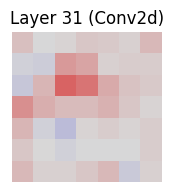

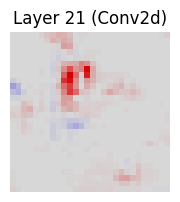

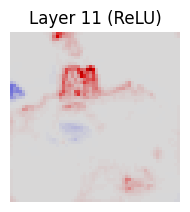

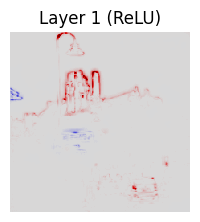

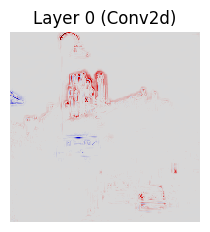

In [16]:
for i,l in enumerate([31,21,11,1,0]):
    utils.heatmap(np.array(R_comp[l][0]).sum(axis=0),0.1*i+1.5,0.1*i+1.5, title=f"Layer {l} ({type(layers[l]).__name__})")

## 2. Boolean Semiring

In [17]:
ksize = np.array([layers[l].kernel_size[0] for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"])
shapes = np.array([A[l].shape[3] for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"])

slided_ksize = np.concatenate((ksize[1:], np.array([ksize[-1]])))

theta_0 = 0.0055
epsilon_0 = 0.0045

division = theta_0 * (slided_ksize**2 + 2*np.log(shapes)) + epsilon_0 + 0.0003*(np.arange(16))
#theta_0 * slided_ksize**2/(epsilon_0 + np.sqrt(shapes))

thetas = {}
conv_indices = [l for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"]
for i, l in enumerate(conv_indices):
 thetas[l] = division[i]

thetas

{0: 0.11352810657040545,
 2: 0.11382810657040544,
 5: 0.10650348758424602,
 7: 0.10680348758424602,
 10: 0.09947886859808665,
 12: 0.09977886859808664,
 14: 0.10007886859808664,
 17: 0.09275424961192726,
 19: 0.09305424961192725,
 21: 0.09335424961192725,
 24: 0.08602963062576785,
 26: 0.08632963062576784,
 28: 0.3066296306257678,
 31: 0.03530501163960845,
 34: 0.014199999999999997,
 37: 0.014499999999999999}

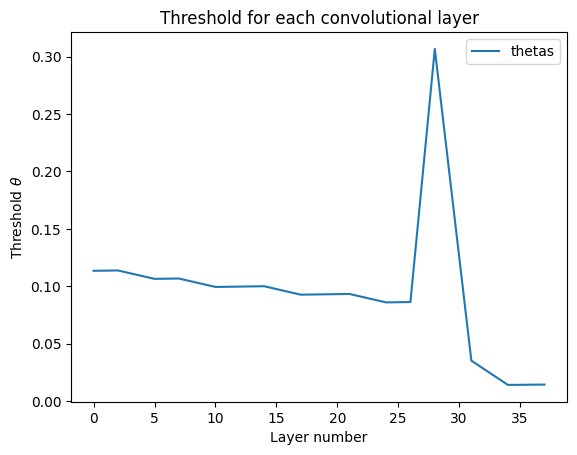

In [18]:
plt.plot(list(thetas), list(thetas.values()), label="thetas")
plt.xlabel("Layer number")
plt.ylabel("Threshold $\\theta$")
plt.title("Threshold for each convolutional layer")
plt.legend()
plt.show()

In [19]:
manual_thetas = {
    0: .05,
    2: .05,
    5: .05,
    7: .05,
    10: .05,
    12: .05,
    14: .06,
    17: .06,
    19: .06,
    21: .1,
    24: .09,
    26: .025,
    28: .3,
    31: .043,
    34: .0145,
    37: .0145
}

thetas = manual_thetas

In [20]:
UPTO = 0

In [21]:
R_new_bool = [None]*L + [(A[-1]*T).data.detach().numpy() > 0]

for l in range(UPTO,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy()

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_new_bool[l] = np.zeros(A[l].shape)

        for chan in range(R_new_bool[l].shape[1]):
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    # TODO: optimize?
                    R_new_bool[l][0,chan,i,j] = (a[0,chan, i, j]>=1e-9) and R_new_bool[l+1][0,chan,i//kernel_size,j//kernel_size]

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_new_bool[l] = np.zeros(A[l].shape, dtype=bool)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        iz = 1/z
        iz = np.array([[np.pad(x, padding, 'constant', constant_values=(1, 1)) for x in iz[0]]])

        zero = False
        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in R_new_bool[l+1][0]]])
        for chan in range(R_new_bool[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    dkernel = a[0,chan,i,j] * kernel
                    dkernel = iz[0,:,i:i+kernel_size[0],j:j+kernel_size[1]] * dkernel
                    dkernel = np.abs(dkernel) > thetas[l]

                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = (zone*dkernel).sum()
                    R_new_bool[l][0,chan,i,j] = product
        
    else:
        R_new_bool[l] = R_new_bool[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 18: ReLU(inplace=T

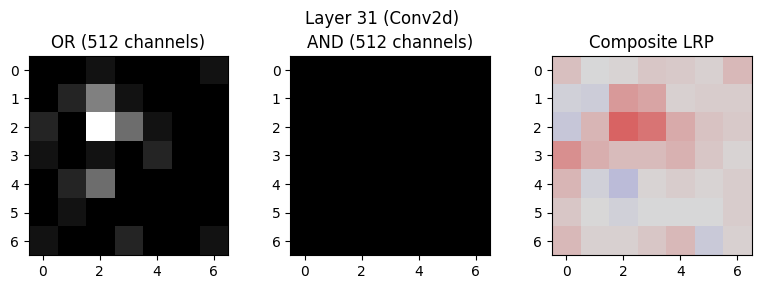

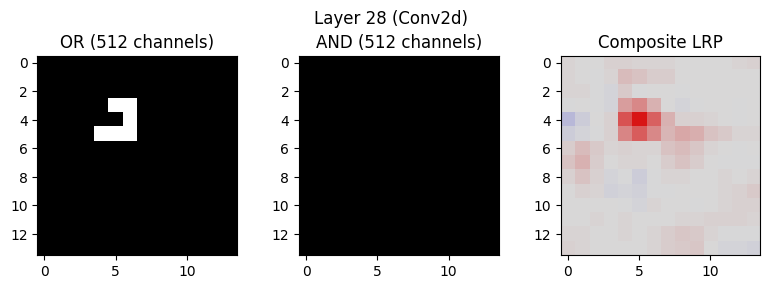

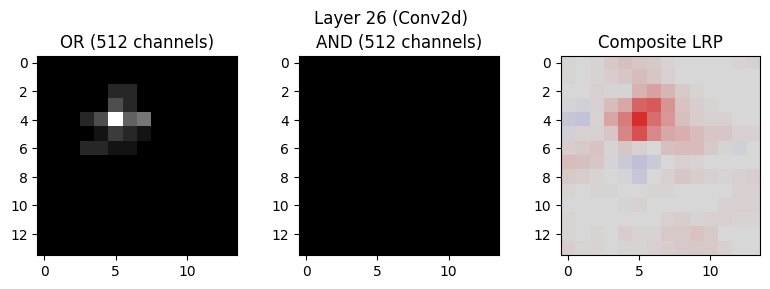

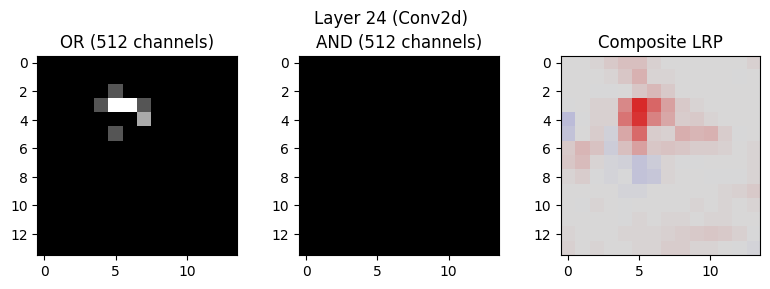

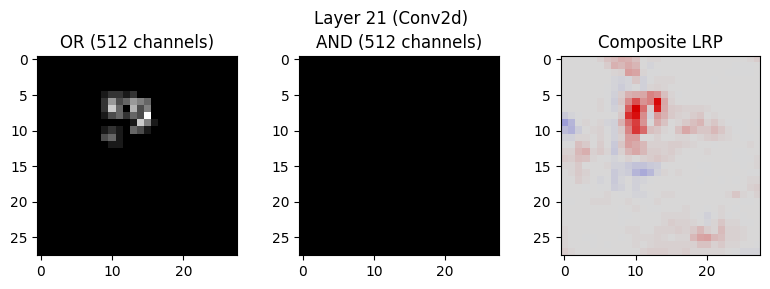

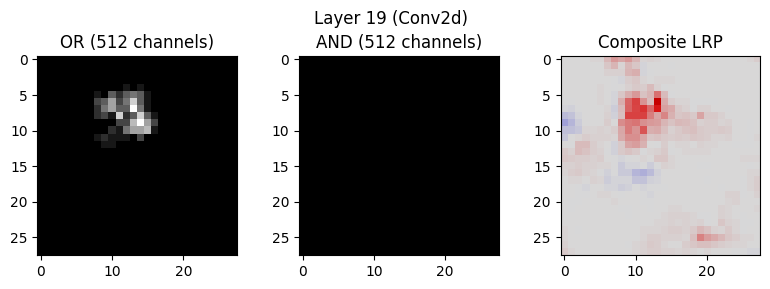

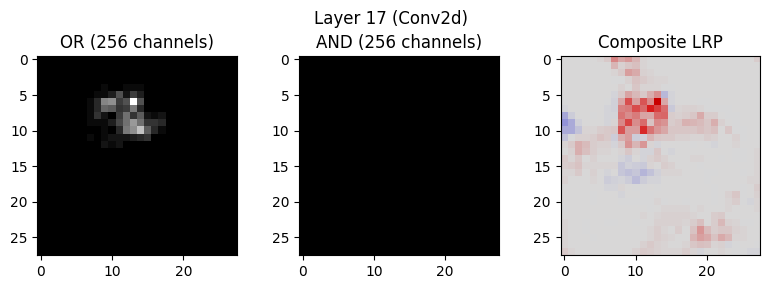

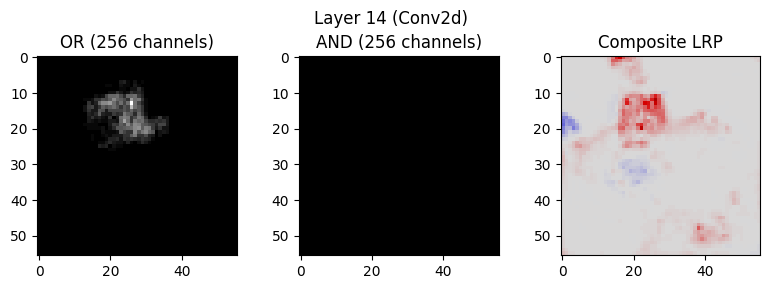

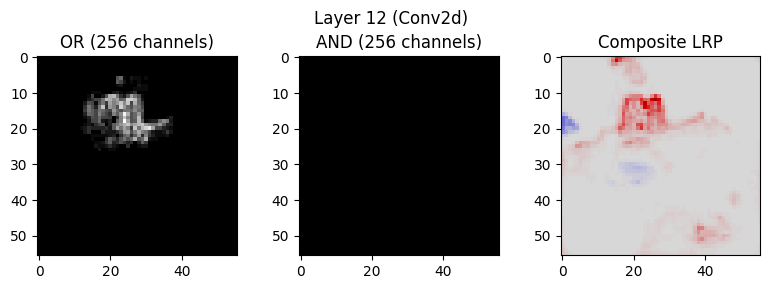

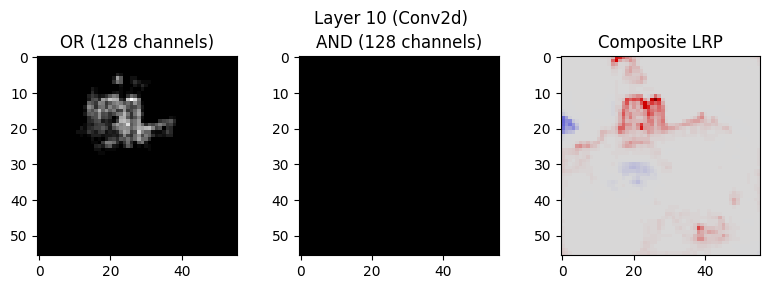

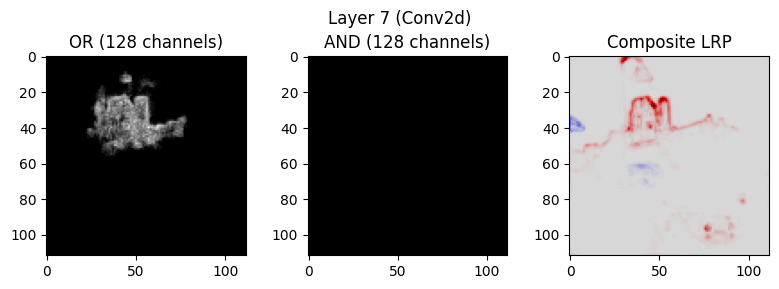

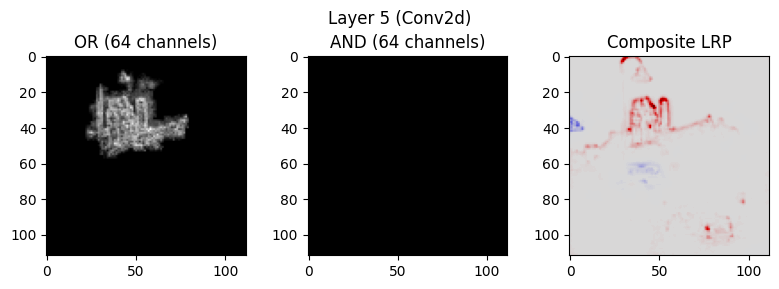

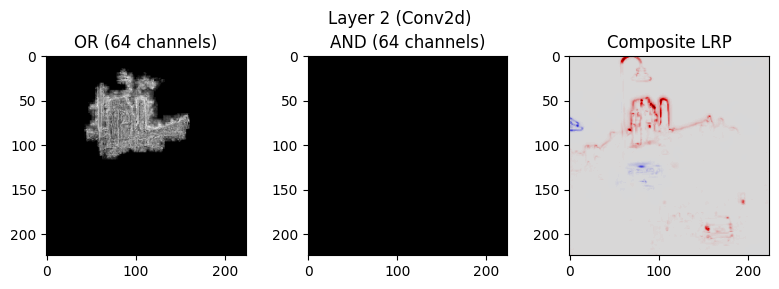

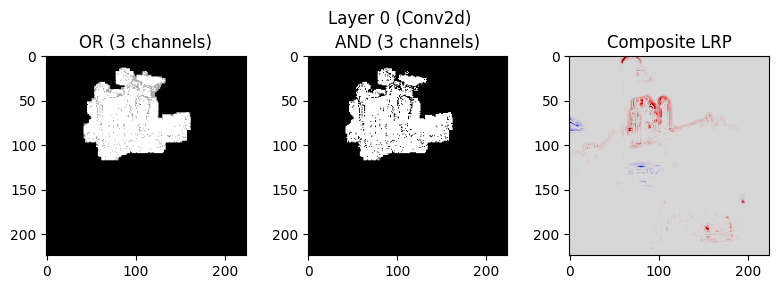

In [31]:
for l in range(UPTO,31+1)[::-1]:
    if type(layers[l]).__name__ != "Conv2d":
        continue
    fig, axs = plt.subplots(1,3, figsize=(8, 5))
    fig.tight_layout()
        
    axs[0].imshow(R_new_bool[l][0].sum(axis=0), cmap="gray")
    axs[0].set_title(f"OR ({A[l].shape[1]} channels)")
    axs[1].imshow(R_new_bool[l][0].prod(axis=0), cmap="gray")
    axs[1].set_title(f"AND ({A[l].shape[1]} channels)")

    b = 10*((np.abs(np.array(R_comp[l][0]).sum(axis=0))**3.0).mean()**(1.0/3))
    axs[2].imshow(np.array(R_comp[l][0]).sum(axis=0), vmin=-b, vmax=b, cmap=my_cmap)
    axs[2].set_title("Composite LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.3)
    plt.show()

## 3. Counting Semiring

In [ ]:
UPTO = 0

In [20]:
R_count = [None]*L + [np.vectorize(np.uint)((A[-1]*T).data.detach().numpy() > 0)]

thetas = {
    0: .01,
    2: .01,
    5: .015,
    7: .02,
    10: .02,
    12: .02,
    14: .03,
    17: .03,
    19: .03,
    21: .06,
    24: .05,
    26: .01,
    28: .3,
    31: .043,
    34: .0145,
    37: .0145
}

for l in range(UPTO,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy()

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_count[l] = np.zeros(A[l].shape)

        for chan in range(R_count[l].shape[1]):
            for i in range(R_count[l].shape[2]):
                for j in range(R_count[l].shape[3]):
                    # TODO: optimize?
                    R_count[l][0,chan,i,j] = int(a[0,chan, i, j]>=1e-9) * R_count[l+1][0,chan,i//kernel_size,j//kernel_size]

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_count[l] = np.zeros(A[l].shape, dtype=np.uint)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        iz = 1/z
        iz = np.array([[np.pad(x, padding, 'constant', constant_values=(1, 1)) for x in iz[0]]])

        zero = 0
        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in R_count[l+1][0]]])
        for chan in range(A[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(A[l].shape[2]):
                for j in range(A[l].shape[3]):
                    dkernel = a[0,chan,i,j] * kernel
                    dkernel = iz[0,:,i:i+kernel_size[0],j:j+kernel_size[1]] * dkernel
                    dkernel = np.vectorize(int)(np.abs(dkernel) > thetas[l])

                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = (zone*dkernel).sum()
                    R_count[l][0,chan,i,j] = product
        
    else:
        R_count[l] = R_count[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 18: ReLU(inplace=T

In [9]:
for l in range(UPTO,31+1)[::-1]:
    if type(layers[l]).__name__ != "Conv2d":
        continue
    fig, axs = plt.subplots(1,2)
    fig.tight_layout()
        
    axs[0].imshow(R_count[l][0].sum(axis=0), cmap="gray")
    axs[0].set_title(f"Counting - Sum over {A[l].shape[1]} channels")

    axs[1].imshow(R_comp[l][0].sum(axis=0))
    axs[1].set_title("Simplified LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.1)
    plt.show()

NameError: name 'UPTO' is not defined

## 4. Viterbi Semiring

In [30]:
R_vit = [None]*L + [np.vectorize(int)((A[-1]*T).data.detach().numpy() > 0)]

for l in range(0,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy()

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_vit[l] = np.zeros(A[l].shape)

        for chan in range(A[l].shape[1]):
            for i in range(A[l].shape[2]):
                for j in range(A[l].shape[3]):
                    # TODO: optimize?
                    R_vit[l][0,chan,i,j] = int(a[0,chan, i, j]>=1e-9) * R_vit[l+1][0,chan,i//kernel_size,j//kernel_size] / (kernel_size * kernel_size)

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_vit[l] = np.zeros(A[l].shape, dtype=np.float64)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        iz = 1/z
        iz = np.array([[np.pad(x, padding, 'constant', constant_values=(1, 1)) for x in iz[0]]])

        zero = 0
        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in R_vit[l+1][0]]])
        for chan in range(A[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(A[l].shape[2]):
                for j in range(A[l].shape[3]):
                    dkernel = a[0,chan,i,j] * kernel
                    dkernel = iz[0,:,i:i+kernel_size[0],j:j+kernel_size[1]] * dkernel
                    dkernel = np.abs(dkernel)

                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]

                    product = (zone*dkernel).max()
                    R_vit[l][0,chan,i,j] = product
        
    else:
        R_vit[l] = R_vit[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 18: ReLU(inplace=T

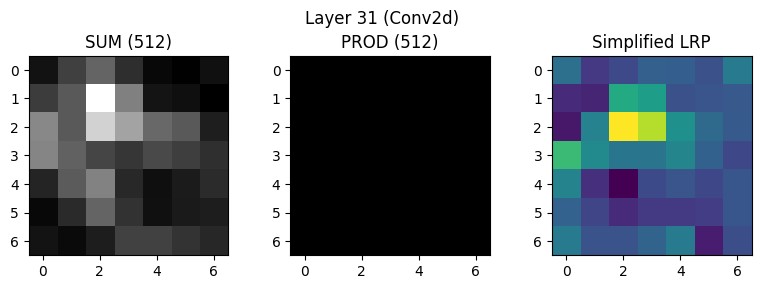

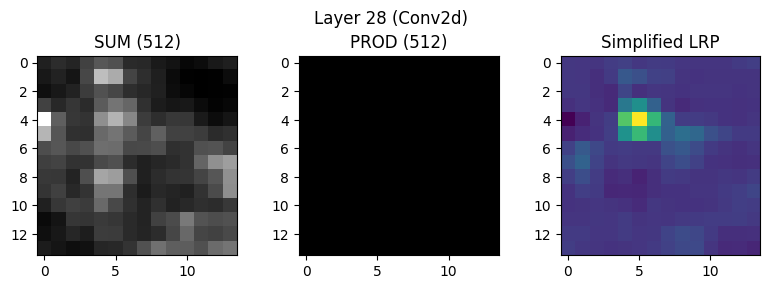

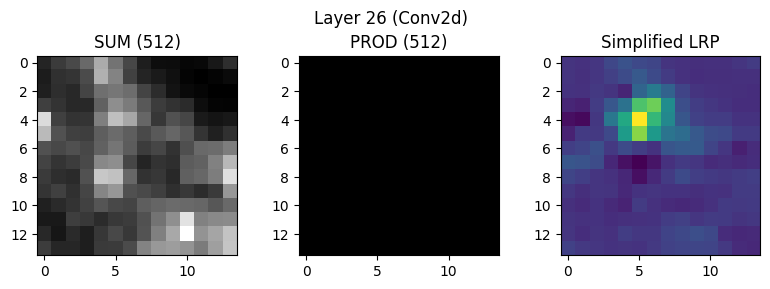

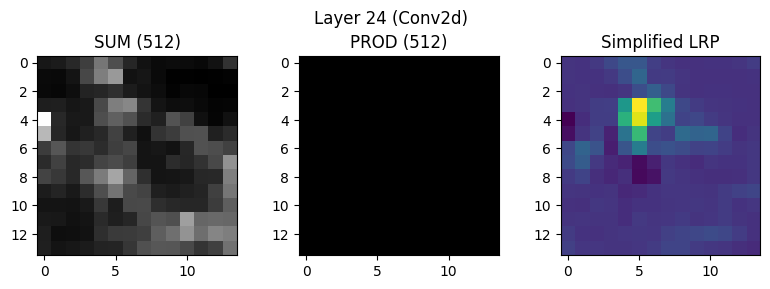

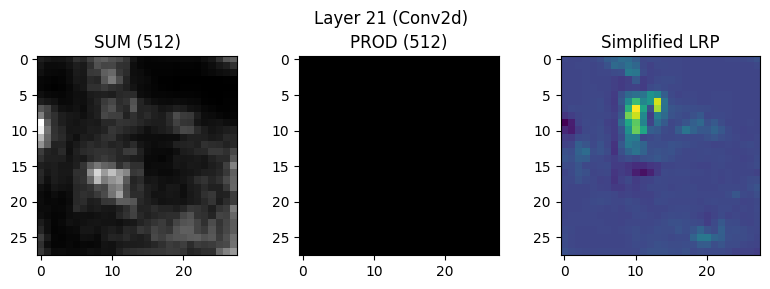

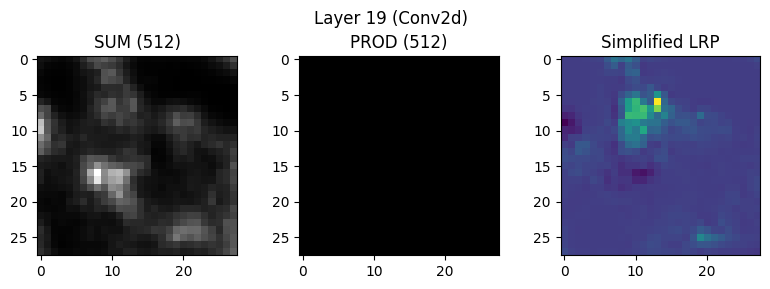

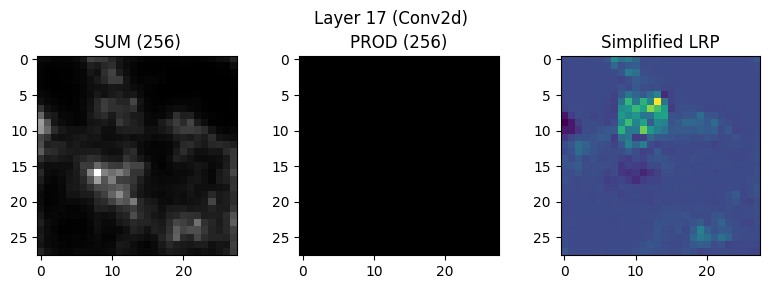

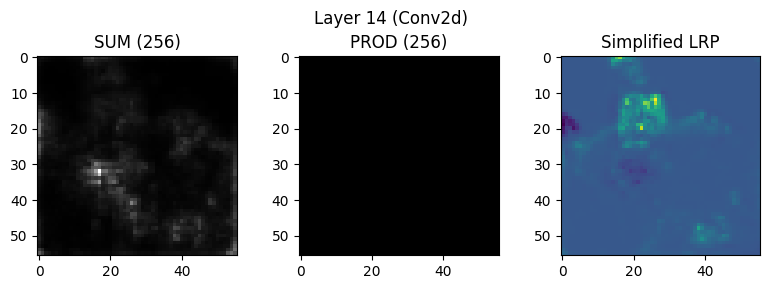

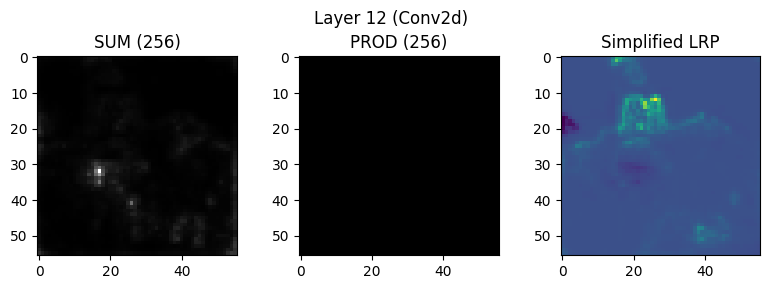

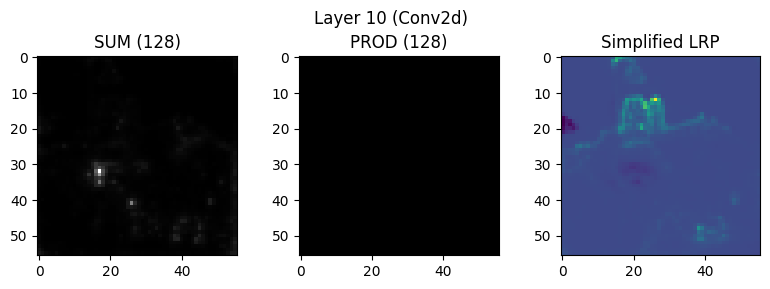

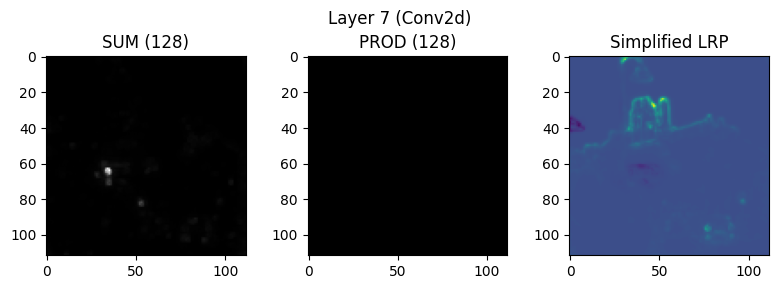

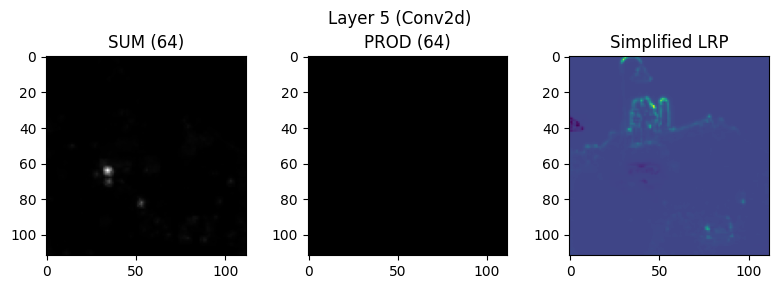

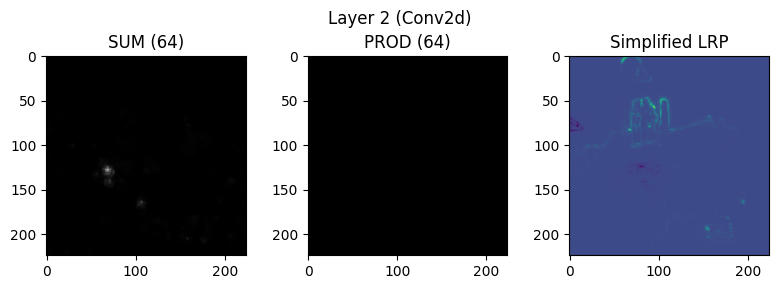

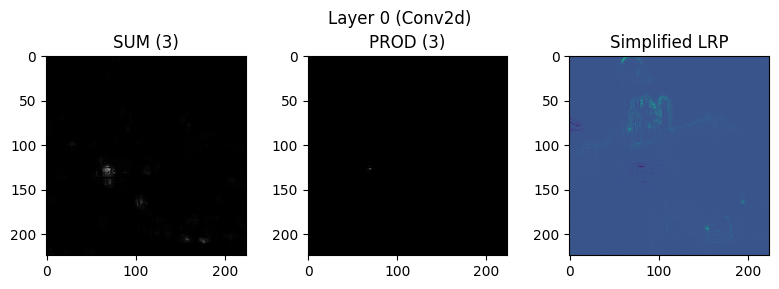

In [31]:
for l in range(0,31+1)[::-1]:
    if type(layers[l]).__name__ != "Conv2d":
        continue
    fig, axs = plt.subplots(1,3, figsize=(8, 5))
    fig.tight_layout()
        
    axs[0].imshow(R_vit[l][0].sum(axis=0), cmap="gray")
    axs[0].set_title(f"SUM ({A[l].shape[1]})")
    axs[1].imshow(R_vit[l][0].prod(axis=0), cmap="gray")
    axs[1].set_title(f"PROD ({A[l].shape[1]})")

    axs[2].imshow(R_comp[l][0].sum(axis=0))
    axs[2].set_title("Simplified LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.3)
    plt.show()